In [1]:
import json
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
import copy
from matplotlib import pyplot as plt
from endolas import utils

Segmentation Models: using `tf.keras` framework.


In [2]:
#utils._init_plot()

In [3]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [4]:
file = open('161_w_60.json')
json_data = json.load(file)
new_json = dict()
for key, values in json_data.items():
    if values[0] > 2 or values[1] > 2:
        new_json[key] = values
        
data = np.zeros((len(new_json),2))
for i, values in enumerate(new_json.values()):
    data[i][0] = values[0]
    data[i][1] = values[1]

In [5]:
file = open('fix.json')
json_data_fix = json.load(file)

new_json_fix = dict()
for key, values in json_data_fix.items():
    try:
        new_json[key]
    except KeyError:
        continue
        
    new_json_fix[key] = values
    

data_fix = np.zeros((len(json_data_fix),2))
for i, values in enumerate(json_data_fix.values()):

    data_fix[i][0] = values[0] / 2
    data_fix[i][1] = values[1] / 2

In [6]:
vor = Voronoi(data)

In [12]:
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['legend.fontsize'] = 14

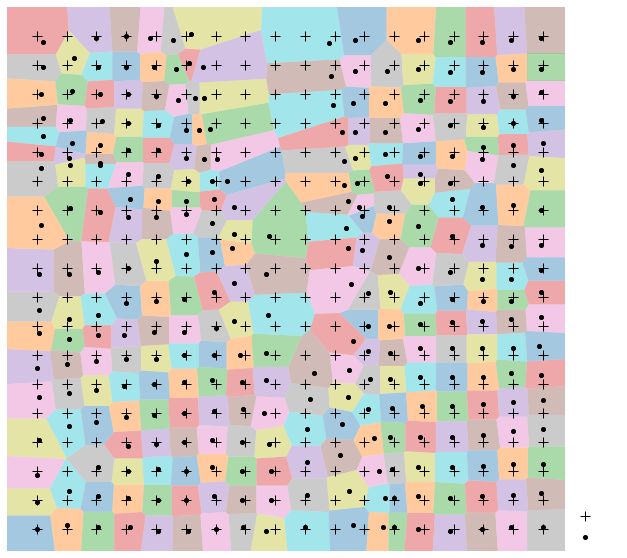

In [24]:
# make up data points
#np.random.seed(1234)
#points = np.random.rand(15, 2)

# compute Voronoi tesselation
#vor = Voronoi(points)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)
#print("--")
#print(regions)
#print("--")
#print(vertices)

# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

ax = plt.plot(data_fix[:,0], data_fix[:,1], 'k+', markersize=10, label=' ')
ax = plt.plot(data[:,0], data[:,1], 'ko', markersize=4, label=' ')
#plt.axis('equal')
#plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
#plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)#

plt.xlim([40, 340])
plt.ylim([40, 340])

plt.axis('off')

plt.xticks([40, 100, 200, 300, 340])
plt.yticks([40, 340])
plt.gca().invert_yaxis()
plt.legend(loc=(1.0, 0.0), frameon=False)
plt.savefig('voro.png')

plt.show()